<a href="https://colab.research.google.com/github/AnushkaAmte/Preprocessing/blob/main/line_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.filters import threshold_otsu
from skimage.util import invert
import numpy as np
import matplotlib.pyplot as plt
from heapq import *

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  """Entry point for launching an IPython kernel.


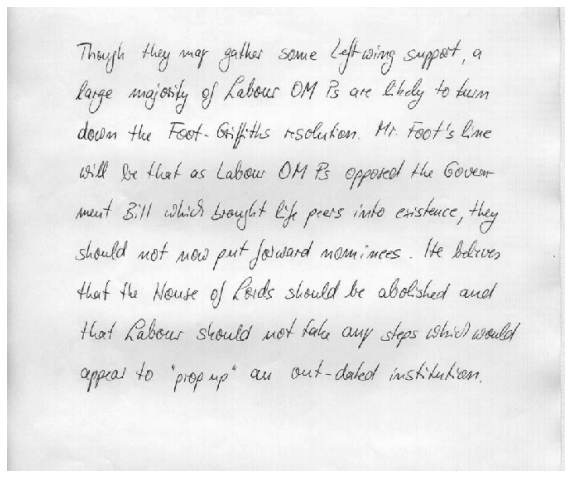

In [19]:
img = rgb2gray(imread("handwritten2.png"))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(img, cmap="gray")
plt.show()

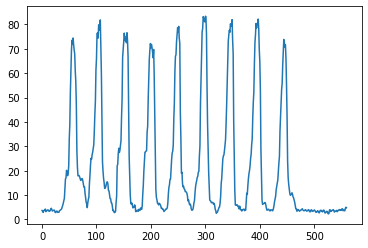

In [20]:
def horizontal_projections(sobel_image):
    return np.sum(sobel_image, axis=1)  

sobel_image = sobel(img)
hpp = horizontal_projections(sobel_image)
plt.plot(hpp)
plt.show()

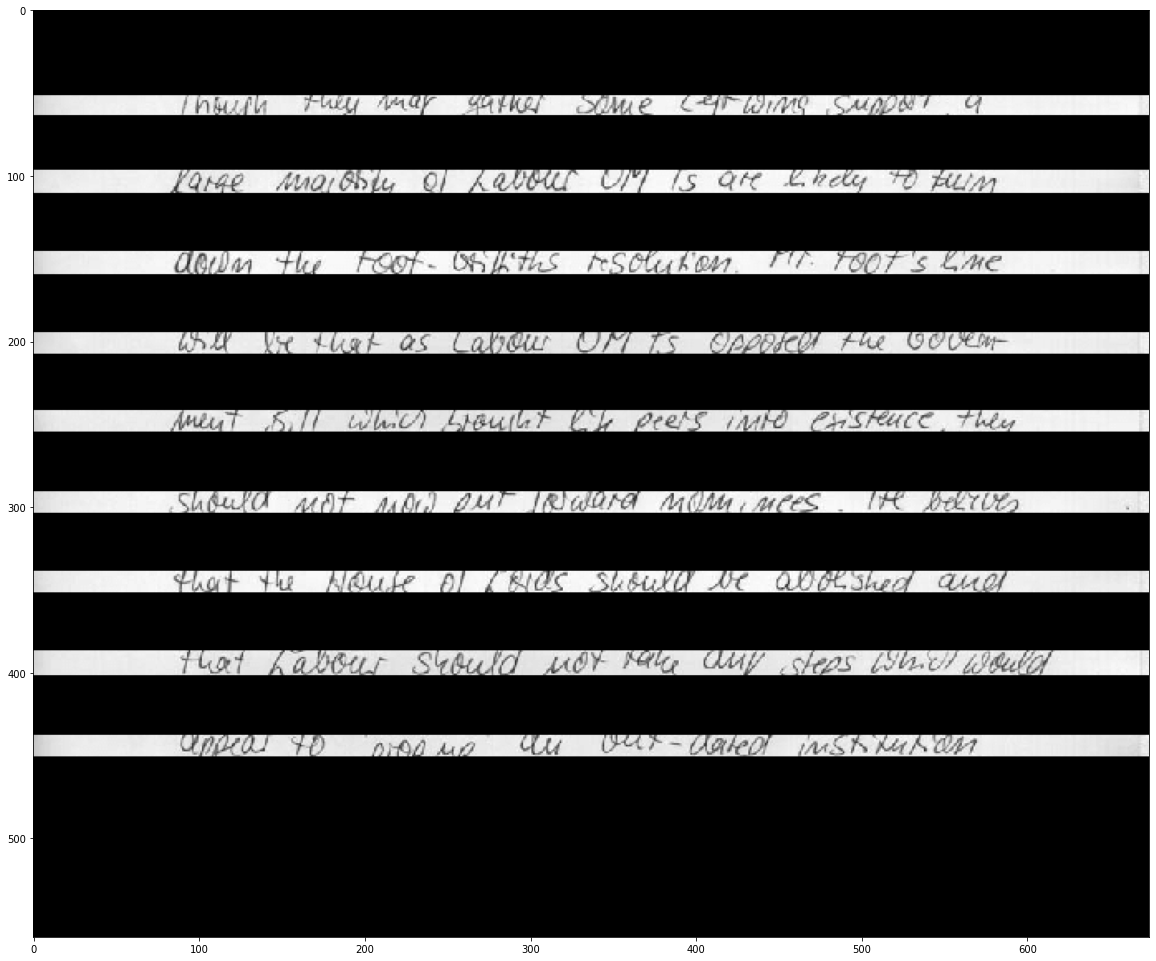

In [21]:
def find_peak_regions(hpp, divider=2):
    threshold = (np.max(hpp)-np.min(hpp))/divider
    peaks = []
    peaks_index = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append([i, hppv])
    return peaks

peaks = find_peak_regions(hpp)

peaks_index = np.array(peaks)[:,0].astype(int)

segmented_img = np.copy(img)
r,c = segmented_img.shape
for ri in range(r):
    if ri in peaks_index:
        segmented_img[ri, :] = 0
        
plt.figure(figsize=(20,20))
plt.imshow(segmented_img, cmap="gray")
plt.show()

In [22]:
def get_hpp_walking_regions(peaks_index):
    hpp_clusters = []
    cluster = []
    for index, value in enumerate(peaks_index):
        cluster.append(value)

        if index < len(peaks_index)-1 and peaks_index[index+1] - value > 1:
            hpp_clusters.append(cluster)
            cluster = []

        #get the last cluster
        if index == len(peaks_index)-1:
            hpp_clusters.append(cluster)
            cluster = []
            
    return hpp_clusters

hpp_clusters = get_hpp_walking_regions(peaks_index)

In [23]:
def heuristic(a, b):
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

def astar(array, start, goal):

    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []

    heappush(oheap, (fscore[start], start))
    
    while oheap:

        current = heappop(oheap)[1]

        if current == goal:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j            
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:                
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue
                
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue
                
            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))
                
    return []

In [25]:
def get_binary(img):
    mean = np.mean(img)
    if mean == 0.0 or mean == 1.0:
        return img

    thresh = threshold_otsu(img)
    binary = img <= thresh
    binary = binary*1
    return binary

def path_exists(window_image):
    #very basic check first then proceed to A* check
    if 0 in horizontal_projections(window_image):
        return True
    
    padded_window = np.zeros((window_image.shape[0],1))
    world_map = np.hstack((padded_window, np.hstack((window_image,padded_window)) ) )
    path = np.array(astar(world_map, (int(world_map.shape[0]/2), 0), (int(world_map.shape[0]/2), world_map.shape[1])))
    if len(path) > 0:
        return True
    
    return False

def get_road_block_regions(nmap):
    road_blocks = []
    needtobreak = False
    
    for col in range(nmap.shape[1]):
        start = col
        end = col+20
        if end > nmap.shape[1]-1:
            end = nmap.shape[1]-1
            needtobreak = True

        if path_exists(nmap[:, start:end]) == False:
            road_blocks.append(col)

        if needtobreak == True:
            break
            
    return road_blocks

def group_the_road_blocks(road_blocks):
    #group the road blocks
    road_blocks_cluster_groups = []
    road_blocks_cluster = []
    size = len(road_blocks)
    for index, value in enumerate(road_blocks):
        road_blocks_cluster.append(value)
        if index < size-1 and (road_blocks[index+1] - road_blocks[index]) > 1:
            road_blocks_cluster_groups.append([road_blocks_cluster[0], road_blocks_cluster[len(road_blocks_cluster)-1]])
            road_blocks_cluster = []

        if index == size-1 and len(road_blocks_cluster) > 0:
            road_blocks_cluster_groups.append([road_blocks_cluster[0], road_blocks_cluster[len(road_blocks_cluster)-1]])
            road_blocks_cluster = []

    return road_blocks_cluster_groups

binary_image = get_binary(img)

for cluster_of_interest in hpp_clusters:
    nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
    road_blocks = get_road_block_regions(nmap)
    road_blocks_cluster_groups = group_the_road_blocks(road_blocks)
    #create the doorways
    for index, road_blocks in enumerate(road_blocks_cluster_groups):
        window_image = nmap[:, road_blocks[0]: road_blocks[1]+10]
        binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:][:, road_blocks[0]: road_blocks[1]+10][int(window_image.shape[0]/2),:] *= 0

In [26]:
line_segments = []
for i, cluster_of_interest in enumerate(hpp_clusters):
    nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
    path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
    offset_from_top = cluster_of_interest[0]
    path[:,0] += offset_from_top
    line_segments.append(path)

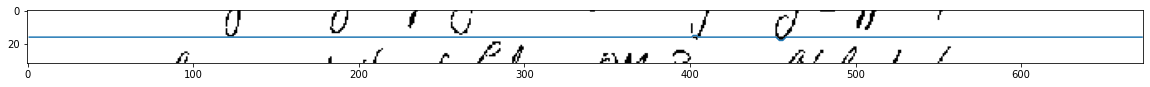

In [27]:
cluster_of_interest = hpp_clusters[1]
offset_from_top = cluster_of_interest[0]
nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
plt.figure(figsize=(20,20))
plt.imshow(invert(nmap), cmap="gray")

path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
plt.plot(path[:,1], path[:,0])

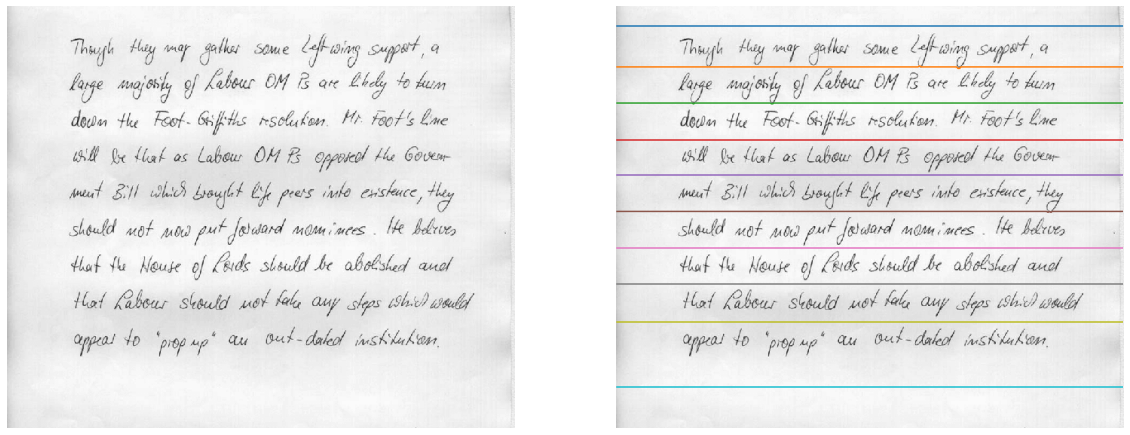

In [28]:
offset_from_top = cluster_of_interest[0]
fig, ax = plt.subplots(figsize=(20,10), ncols=2)
for path in line_segments:
    ax[1].plot((path[:,1]), path[:,0])
ax[1].axis("off")
ax[0].axis("off")
ax[1].imshow(img, cmap="gray")
ax[0].imshow(img, cmap="gray")

In [29]:
last_bottom_row = np.flip(np.column_stack(((np.ones((img.shape[1],))*img.shape[0]), np.arange(img.shape[1]))).astype(int), axis=0)
line_segments.append(last_bottom_row)

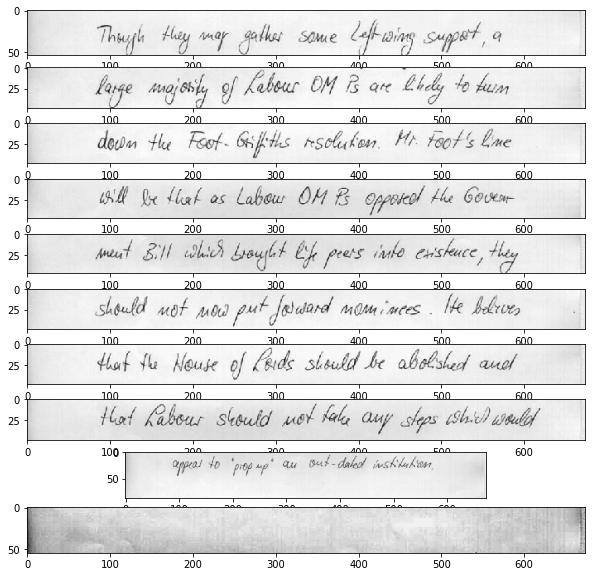

In [30]:
line_images = []
def extract_line_from_image(image, lower_line, upper_line):
    lower_boundary = np.min(lower_line[:, 0])
    upper_boundary = np.min(upper_line[:, 0])
    img_copy = np.copy(image)
    r, c = img_copy.shape
    for index in range(c-1):
        img_copy[0:lower_line[index, 0], index] = 255
        img_copy[upper_line[index, 0]:r, index] = 255
    
    return img_copy[lower_boundary:upper_boundary, :]

line_count = len(line_segments)
fig, ax = plt.subplots(figsize=(10,10), nrows=line_count-1)
for line_index in range(line_count-1):
    line_image = extract_line_from_image(img, line_segments[line_index], line_segments[line_index+1])
    line_images.append(line_image)
    ax[line_index].imshow(line_image, cmap="gray")

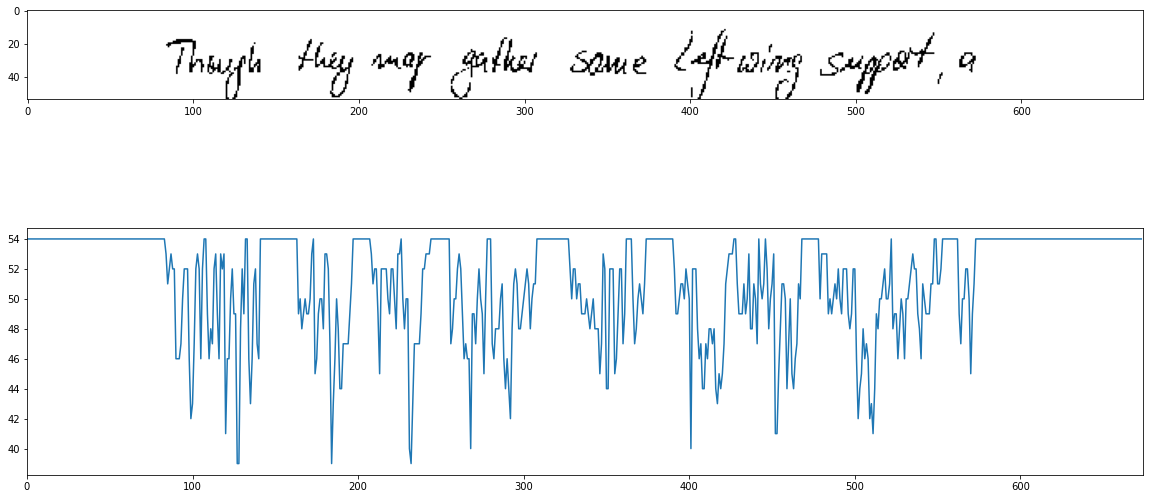

In [31]:
first_line = line_images[0]
thresh = threshold_otsu(first_line)
binary = first_line > thresh

# find the vertical projection by adding up the values of all pixels along rows
vertical_projection = np.sum(binary, axis=0)

# plot the vertical projects
fig, ax = plt.subplots(nrows=2, figsize=(20,10))
plt.xlim(0, first_line.shape[1])
ax[0].imshow(binary, cmap="gray")
ax[1].plot(vertical_projection)

In [32]:
height = first_line.shape[0]

## we will go through the vertical projections and 
## find the sequence of consecutive white spaces in the image
whitespace_lengths = []
whitespace = 0
for vp in vertical_projection:
    if vp == height:
        whitespace = whitespace + 1
    elif vp != height:
        if whitespace != 0:
            whitespace_lengths.append(whitespace)
        whitespace = 0 # reset whitepsace counter. 

print("whitespaces:", whitespace_lengths)
avg_white_space_length = np.mean(whitespace_lengths)
print("average whitespace lenght:", avg_white_space_length)

whitespaces: [84, 2, 2, 23, 1, 11, 1, 12, 3, 20, 4, 17, 2, 1, 1, 11, 1, 2, 10]
average whitespace lenght: 10.947368421052632


In [33]:
whitespace_length = 0
divider_indexes = []
for index, vp in enumerate(vertical_projection):
    if vp == height:
        whitespace_length = whitespace_length + 1
    elif vp != height:
        if whitespace_length != 0 and whitespace_length > avg_white_space_length:
            divider_indexes.append(index-int(whitespace_length/2))
            whitespace_length = 0 # reset it
            
print(divider_indexes)

[42, 151, 202, 250, 317, 381, 472, 557]


In [34]:
divider_indexes = np.array(divider_indexes)
dividers = np.column_stack((divider_indexes[:-1],divider_indexes[1:]))

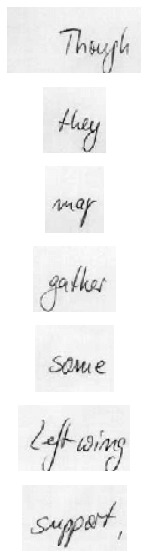

In [38]:
fig, ax = plt.subplots(nrows=len(dividers), figsize=(5,10))
for index, window in enumerate(dividers):
    ax[index].axis("off")
    ax[index].imshow(first_line[:,window[0]:window[1]], cmap="gray")